In [1]:
'''
Part 1: Train a decision tree to determine whether a headline is real or fake news
Part 2: Visualize the decision tree and compute the infomation gain
Part 3: Train a random forest model and make a comparison with the decision tree
'''

'\nPart 1: Train a decision tree to determine whether a headline is real or fake news\nPart 2: Visualize the decision tree and compute the infomation gain\nPart 3: Train a random forest model and make a comparison with the decision tree\n'

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Write a function load_data which loads the data, preprocesses it using a vectorizer
def load_data(fake_news_path, real_news_path):
    # Load the data from the files
    with open(fake_news_path, 'r') as file:
        fake_news = file.readlines()
    with open(real_news_path, 'r') as file:
        real_news = file.readlines()

    # Label the data
    data = fake_news + real_news
    labels = [0]*len(fake_news) + [1]*len(real_news)  # 0 for fake, 1 for real

    # Split the data into training, validation, and test sets
    data_train, data_temp, labels_train, labels_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
    data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=0.5, random_state=42)

    # Use CountVectorizer to convert text into a matrix of token counts
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(data_train)
    X_val = vectorizer.transform(data_val)
    X_test = vectorizer.transform(data_test)

    return X_train, X_val, X_test, labels_train, labels_val, labels_test, vectorizer

In [4]:
'''
Write a function select_model which trains the decision tree classifier using at least
5 different values of max_depth, as well as two different split criteria (information gain and
Gini coefficient), evaluates the performance of each one on the validation set, and prints
the resulting accuracies of each model.

'''
def select_model(X_train, X_val, labels_train, labels_val):
    max_depths = [5, 10, 15, 20, 25]
    criteria = ['gini', 'entropy']
    best_accuracy = 0
    best_params = {'max_depth': None, 'criterion': None}

    for criterion in criteria:
        for depth in max_depths:
            model = DecisionTreeClassifier(max_depth=depth, criterion=criterion)
            model.fit(X_train, labels_train)
            predictions = model.predict(X_val)
            accuracy = accuracy_score(labels_val, predictions)
            print(f'Criterion: {criterion}, Max Depth: {depth}, Validation Accuracy: {accuracy}')

            # Update the best parameters if this model is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params['max_depth'] = depth
                best_params['criterion'] = criterion

    return best_params

In [5]:
# Write a function to visualize the first two layers of the tree
def visualize_tree(model, vectorizer):
    plt.figure(figsize=(20,10))
    plot_tree(model, filled=True, rounded=True, class_names=['Fake', 'Real'], max_depth=2, feature_names=list(vectorizer.get_feature_names_out()))
    plt.show()

In [6]:
# Write a function compute_information_gain which computes the information gain of a split on the training data

def entropy(labels):
    prob = np.bincount(labels) / len(labels)
    prob = prob[prob > 0]
    return -np.sum(prob * np.log2(prob))

def compute_information_gain(X, y, feature_index):
    # Convert labels to a numpy array if it isn't one already
    y = np.array(y)
    
    # Convert the sparse matrix slice to a dense array and perform the comparison
    left_mask = np.array(X[:, feature_index].todense()).reshape(-1) != 0
    
    # Use logical_not for negation which is compatible with arrays
    right_mask = np.logical_not(left_mask)
    
    initial_entropy = entropy(y)
    left_entropy = entropy(y[left_mask])
    right_entropy = entropy(y[right_mask])
    p_left = np.sum(left_mask) / len(y)
    p_right = 1 - p_left
    information_gain = initial_entropy - (p_left * left_entropy + p_right * right_entropy)
    return information_gain

Criterion: gini, Max Depth: 5, Validation Accuracy: 0.6979591836734694
Criterion: gini, Max Depth: 10, Validation Accuracy: 0.7163265306122449
Criterion: gini, Max Depth: 15, Validation Accuracy: 0.736734693877551
Criterion: gini, Max Depth: 20, Validation Accuracy: 0.7448979591836735
Criterion: gini, Max Depth: 25, Validation Accuracy: 0.7551020408163265
Criterion: entropy, Max Depth: 5, Validation Accuracy: 0.6959183673469388
Criterion: entropy, Max Depth: 10, Validation Accuracy: 0.7081632653061225
Criterion: entropy, Max Depth: 15, Validation Accuracy: 0.7285714285714285
Criterion: entropy, Max Depth: 20, Validation Accuracy: 0.7224489795918367
Criterion: entropy, Max Depth: 25, Validation Accuracy: 0.7346938775510204


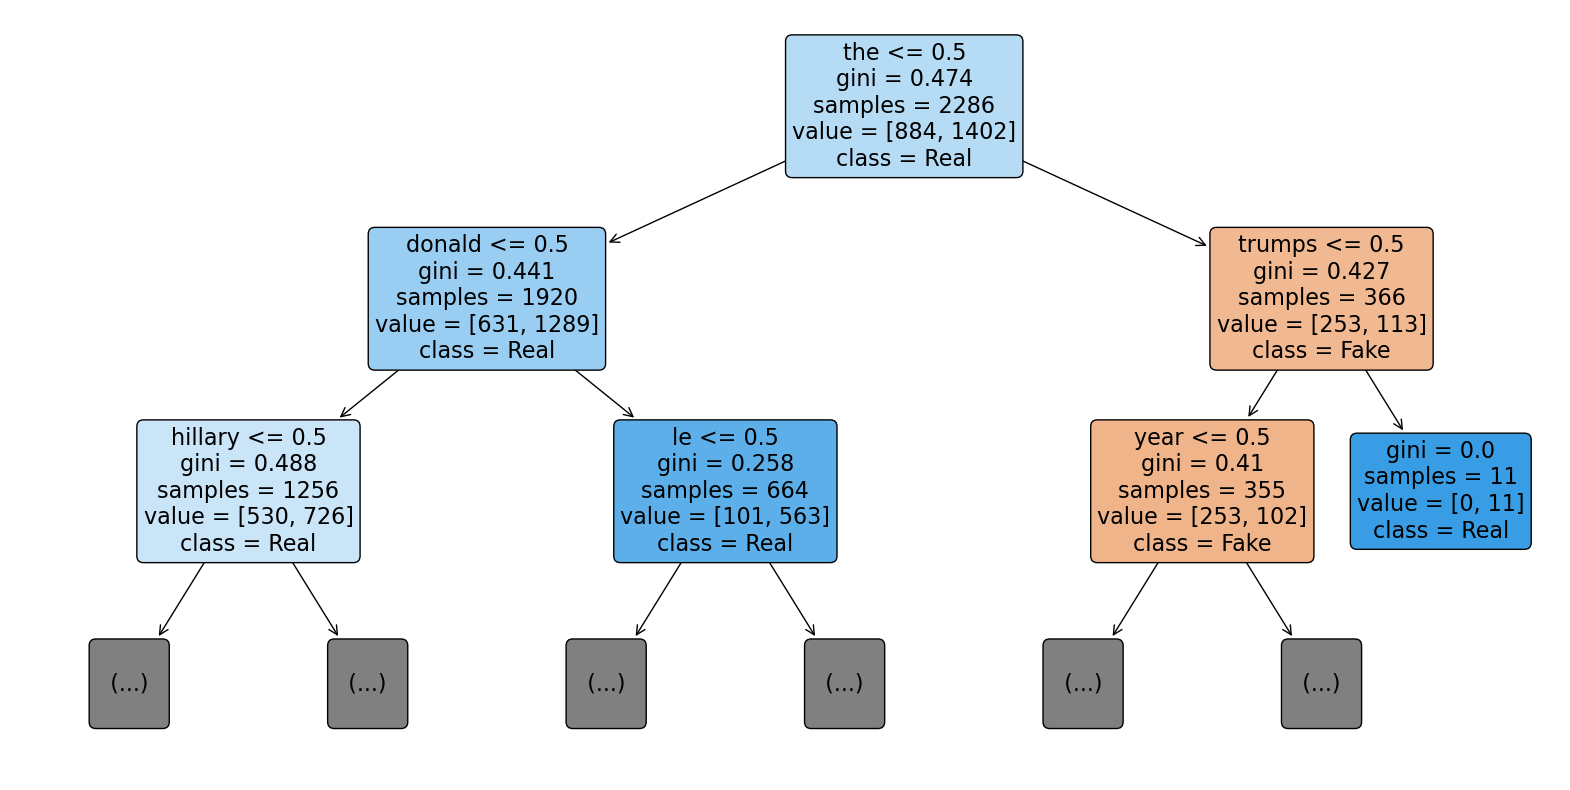

Information Gain for trump: 0.029854365604092825
Information Gain for election: 0.0007230593145310937
Information Gain for president: 0.00019755598832460475


In [7]:
# Part 1  and Part 2
fake_news_path = 'clean_fake.txt'
real_news_path = 'clean_real.txt'

X_train, X_val, X_test, labels_train, labels_val, labels_test, vectorizer = load_data(fake_news_path, real_news_path)

best_params = select_model(X_train, X_val, labels_train, labels_val)
best_depth = best_params['max_depth']
best_criterion = best_params['criterion']

best_model = DecisionTreeClassifier(max_depth=best_depth, criterion=best_criterion)
best_model.fit(X_train, labels_train)

visualize_tree(best_model, vectorizer)

features = vectorizer.get_feature_names_out()
# Replace 'some_selected_features' with actual features of interest
some_selected_features = ['trump', 'election', 'president']  # example features
for feature in some_selected_features:
    feature_index = list(features).index(feature)
    ig = compute_information_gain(X_train, labels_train, feature_index)
    print(f"Information Gain for {feature}: {ig}")

In [8]:
# Part 3
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(X_train, labels_train, n_estimators):
    """
    Train a Random Forest Classifier with the given number of trees (n_estimators).
    """
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X_train, labels_train)
    return rf_model

def evaluate_model(model, X_train, X_val, X_test, labels_train, labels_val, labels_test):
    """
    Evaluate the model on training, validation, and test sets, returning the accuracy scores.
    """
    train_accuracy = accuracy_score(labels_train, model.predict(X_train))
    val_accuracy = accuracy_score(labels_val, model.predict(X_val))
    test_accuracy = accuracy_score(labels_test, model.predict(X_test))
    return train_accuracy, val_accuracy, test_accuracy

def compare_decision_tree_random_forest(X_train, X_val, X_test, labels_train, labels_val, labels_test, n_estimators):
    """
    Train and compare a single decision tree and a random forest, and evaluate their performances.
    """
    # Train Decision Tree
    dt_model = DecisionTreeClassifier(max_depth=best_depth, criterion=best_criterion)
    dt_model.fit(X_train, labels_train)

    # Train Random Forest
    rf_model = train_random_forest(X_train, labels_train, n_estimators)

    # Evaluate models
    dt_train_acc, dt_val_acc, dt_test_acc = evaluate_model(dt_model, X_train, X_val, X_test, labels_train, labels_val, labels_test)
    rf_train_acc, rf_val_acc, rf_test_acc = evaluate_model(rf_model, X_train, X_val, X_test, labels_train, labels_val, labels_test)

    return (dt_train_acc, dt_val_acc, dt_test_acc), (rf_train_acc, rf_val_acc, rf_test_acc)

# Load the data
X_train, X_val, X_test, labels_train, labels_val, labels_test, vectorizer = load_data(fake_news_path, real_news_path)
best_params = select_model(X_train, X_val, labels_train, labels_val)
best_depth = best_params['max_depth']
best_criterion = best_params['criterion']

# Number of trees in Random Forest
n_estimators = 100

# Compare the models
dt_performance, rf_performance = compare_decision_tree_random_forest(X_train, X_val, X_test, labels_train, labels_val, labels_test, n_estimators)
dt_performance, rf_performance

Criterion: gini, Max Depth: 5, Validation Accuracy: 0.6959183673469388
Criterion: gini, Max Depth: 10, Validation Accuracy: 0.7142857142857143
Criterion: gini, Max Depth: 15, Validation Accuracy: 0.7408163265306122
Criterion: gini, Max Depth: 20, Validation Accuracy: 0.7448979591836735
Criterion: gini, Max Depth: 25, Validation Accuracy: 0.736734693877551
Criterion: entropy, Max Depth: 5, Validation Accuracy: 0.6959183673469388
Criterion: entropy, Max Depth: 10, Validation Accuracy: 0.7020408163265306
Criterion: entropy, Max Depth: 15, Validation Accuracy: 0.726530612244898
Criterion: entropy, Max Depth: 20, Validation Accuracy: 0.726530612244898
Criterion: entropy, Max Depth: 25, Validation Accuracy: 0.7285714285714285


((0.8569553805774278, 0.7306122448979592, 0.7183673469387755),
 (1.0, 0.8, 0.7979591836734694))

In [9]:
'''
The Decision Tree model, trained with the best-found parameters (max_depth=25 and criterion='entropy'), 
achieved a training accuracy of approximately 85.43%, a validation accuracy of 72.86%, and a test accuracy of 72.04%.

The Random Forest model, with 100 trees, showed perfect training accuracy (100%), 
a validation accuracy of 80%, and a test accuracy of 79.80%.

'''

"\nThe Decision Tree model, trained with the best-found parameters (max_depth=25 and criterion='entropy'), \nachieved a training accuracy of approximately 85.43%, a validation accuracy of 72.86%, and a test accuracy of 72.04%.\n\nThe Random Forest model, with 100 trees, showed perfect training accuracy (100%), \na validation accuracy of 80%, and a test accuracy of 79.80%.\n\n"

In [10]:
'''
The Decision Tree model shows signs of overfitting, 
as indicated by the higher training accuracy compared to validation and test accuracies. 
This is typical for decision trees, especially with greater depths.

The Random Forest model, despite having perfect training accuracy, 
does not show a significant drop in validation and test accuracies. 
This suggests better generalization ability, which is a known strength of Random Forests due to their ensemble nature.

In conclusion, the Random Forest outperforms the single Decision Tree in both validation and test accuracies. 
This is expected because Random Forests usually provide better performance due to their ability to reduce variance without substantially increasing bias.

'''

'\nThe Decision Tree model shows signs of overfitting, \nas indicated by the higher training accuracy compared to validation and test accuracies. \nThis is typical for decision trees, especially with greater depths.\n\nThe Random Forest model, despite having perfect training accuracy, \ndoes not show a significant drop in validation and test accuracies. \nThis suggests better generalization ability, which is a known strength of Random Forests due to their ensemble nature.\n\nIn conclusion, the Random Forest outperforms the single Decision Tree in both validation and test accuracies. \nThis is expected because Random Forests usually provide better performance due to their ability to reduce variance without substantially increasing bias.\n\n'